# 🌦️ Projeto de Análise Climatológica: Teresina/Timon (2013-2023)

## 1. Visão Geral
Este projeto tem como objetivo analisar o comportamento histórico das chuvas e da temperatura na região de Teresina (PI) e Timon (MA) ao longo da última década. 

A motivação principal foi investigar a percepção popular de mudanças climáticas locais, respondendo a duas perguntas centrais:
1. **O volume de chuvas está diminuindo com o passar dos anos?**
2. **Existe uma relação direta entre os anos mais secos e o aumento da temperatura média?**

In [1]:
# importações de bibliotecas

import pandas as pd
import glob
import matplotlib.pyplot as plt
import os

plt.style.use('seaborn-v0_8-whitegrid')

## 2. Fonte dos Dados
* **Origem:** Dados públicos do INMET (Instituto Nacional de Meteorologia).
* **Estação de Coleta:** Teresina (Código A312).
* **Período:** Série histórica completa de 01/01/2013 a 31/12/2023.
* **Granularidade:** Dados horários agregados para visualização anual.

## 3. Metodologia (Tech Stack) 🛠️
O processamento dos dados foi realizado utilizando a linguagem **Python**, com as seguintes bibliotecas:

* **Pandas:** Utilizado para a manipulação de DataFrames, limpeza de dados (tratamento de *outliers* e valores de erro como `-9999`), conversão de tipos de dados e reamostragem temporal (`resample`).
* **Matplotlib:** Utilizado para a visualização de dados, especificamente para a criação de gráficos de barras e linhas, incluindo a técnica de **Eixo Duplo (Dual Axis)** para correlacionar variáveis de grandezas distintas (milímetros de chuva vs graus Celsius).
* **Glob:** Utilizado para automação da leitura de múltiplos arquivos CSV (ETL), permitindo o processamento de toda a década em um único fluxo.

### Etapas do Processo de ETL (Extract, Transform, Load):
1. **Extração:** Leitura automatizada dos arquivos anuais brutos.
2. **Limpeza:** Remoção de registros inválidos (erros de sensor) e padronização de datas.
3. **Agregação:** Cálculo dos totais anuais de precipitação (`sum`) e médias anuais de temperatura (`mean`).
4. **Exportação:** Geração de um *dataset* consolidado (`.csv`) para uso posterior em ferramentas de BI.


In [2]:
print("🚀 Iniciando o processamento dos dados...")

# Busca arquivos

caminho_busca = '../raw_data/*TERESINA*.csv'
arquivos_encontrados = glob.glob(caminho_busca)

lista_dfs = []

for arquivo in arquivos_encontrados:
    try:
        # Lê o arquivo
        df_temp = pd.read_csv(arquivo, encoding='latin1', sep=';', skiprows=8)
        
        # Padroniza nomes
        mapa_colunas = {
            'Data': 'data', 
            'DATA (YYYY-MM-DD)': 'data',
            'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'chuva',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp'
        }
        df_temp = df_temp.rename(columns=mapa_colunas)
        
        # Filtra e Limpa
        if 'data' in df_temp.columns and 'chuva' in df_temp.columns and 'temp' in df_temp.columns:
            df_temp = df_temp[['data', 'chuva', 'temp']].copy()
            
            # Limpeza Chuva
            df_temp['chuva'] = df_temp['chuva'].astype(str).str.replace(',', '.').astype(float)
            df_temp = df_temp[df_temp['chuva'] >= 0]
            
            # Limpeza Temperatura
            df_temp['temp'] = df_temp['temp'].astype(str).str.replace(',', '.').astype(float)
            df_temp = df_temp[df_temp['temp'] > -50]
            
            # Índice Data
            df_temp['data'] = pd.to_datetime(df_temp['data'])
            df_temp = df_temp.set_index('data')
            
            lista_dfs.append(df_temp)
    except Exception as e:
        print(f"⚠️ Erro ao ler {os.path.basename(arquivo)}: {e}")

# Consolidação
df_completo = pd.concat(lista_dfs).sort_index()

# Cálculos Anuais (Agregações)
chuva_anual = df_completo['chuva'].resample('YE').sum()
temp_anual = df_completo['temp'].resample('YE').mean()

print(f"✅ Dados consolidados de 2013 a 2023! Total de registros: {len(df_completo)}")


🚀 Iniciando o processamento dos dados...
✅ Dados consolidados de 2013 a 2023! Total de registros: 86908


## 4. Visualização de Dados
Abaixo, apresentamos a correlação visual entre a **Precipitação Total (Barras Azuis)** e a **Temperatura Média (Linha Vermelha)** ao longo dos anos.

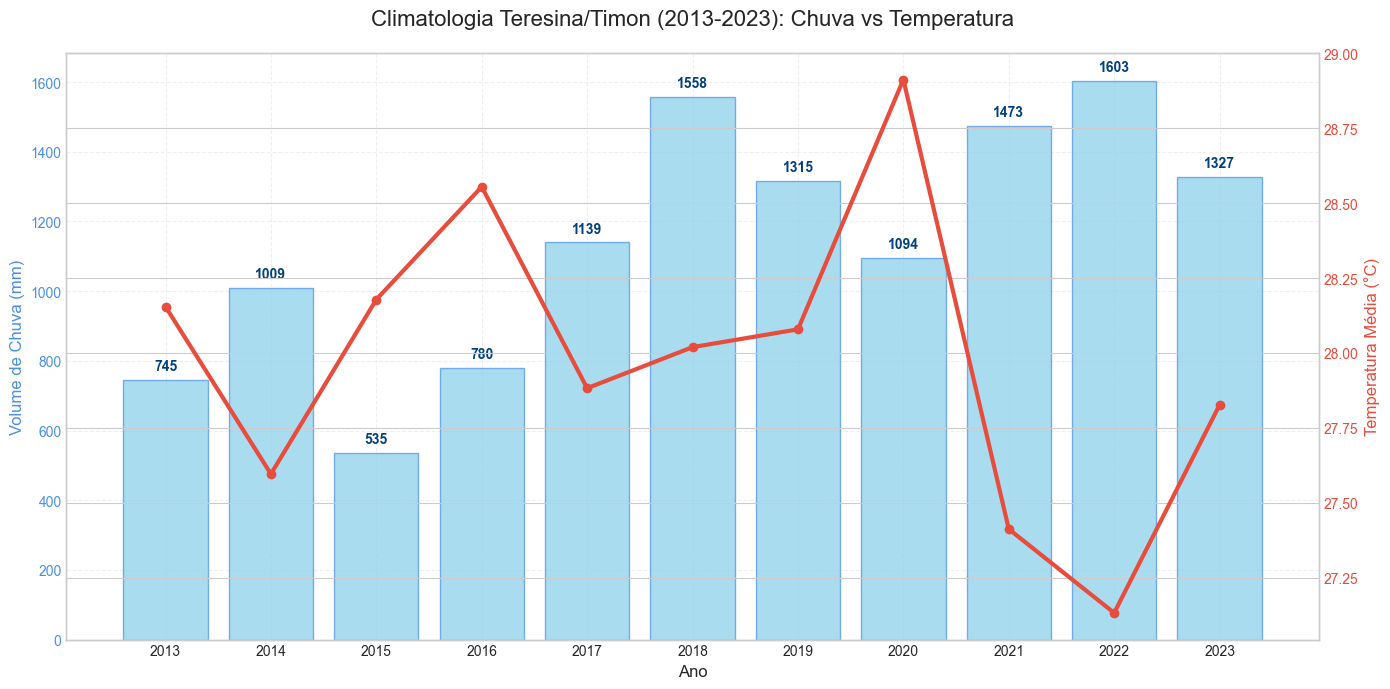

In [3]:
# Configuração da Figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eixo 1: Chuva (Barras)
color_chuva = '#4a90e2'
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_ylabel('Volume de Chuva (mm)', color=color_chuva, fontsize=12)
barras = ax1.bar(chuva_anual.index.year, chuva_anual.values, color='skyblue', edgecolor=color_chuva, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color_chuva)
ax1.set_xticks(chuva_anual.index.year) 

# Rótulos nas barras
for barra in barras:
    altura = barra.get_height()
    ax1.text(barra.get_x() + barra.get_width()/2, altura + 20, 
             f'{int(altura)}', ha='center', va='bottom', color='#004080', fontsize=10, fontweight='bold')

# Eixo 2: Temperatura (Linha)
ax2 = ax1.twinx() 
color_temp = '#e74c3c'
ax2.set_ylabel('Temperatura Média (°C)', color=color_temp, fontsize=12)
ax2.plot(temp_anual.index.year, temp_anual.values, color=color_temp, marker='o', linestyle='-', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color_temp)

# Títulos
plt.title('Climatologia Teresina/Timon (2013-2023): Chuva vs Temperatura', fontsize=16, pad=20)
ax1.grid(True, linestyle='--', alpha=0.3)
fig.tight_layout()

plt.show()

## 5. Conclusões e Insights 📊🚀

A análise da série histórica (2013-2023) revelou padrões climáticos importantes que contradizem algumas percepções do senso comum:

### 1. Tendência de Chuvas (Recuperação Hídrica)
Ao contrário da hipótese de que "está chovendo menos", os dados mostram uma tendência de **aumento no volume de chuvas** na segunda metade da década.
* **O Vale (2013-2016):** O período inicial foi marcado por uma seca severa, com o ano crítico de **2015** registrando apenas **535 mm**.
* **O Pico (2021-2022):** Houve uma recuperação robusta, culminando em **2022** com um recorde de **1.603 mm** (quase o triplo do volume de 2015).

### 2. Correlação Inversa (Chuva x Temperatura)
Foi identificada uma clara **correlação negativa** entre chuva e temperatura. O regime de chuvas atua como o principal regulador térmico da região:
* ❄️ **Anos Chuvosos = Menos Calor:** O ano com maior volume de chuva (2022) registrou a menor temperatura média da década (**27,1°C**).
* 🔥 **Anos Secos = Mais Calor:** Os picos de temperatura média (como 2016 e 2020) coincidiram com anos de chuvas abaixo da média ou irregulares.

---

*Projeto desenvolvido como parte do Portfólio de Dados.*

In [ ]:
# Exportação dos Dados Tratados

import os

caminho_final = '../processed_data/dados_tratados_teresina_2013_2023.csv'

df_export = df_completo.rename(columns={'chuva': 'Precipitacao_mm', 'temp': 'Temperatura_C'})

df_export.to_csv(caminho_final, sep=';', decimal=',')

print(f"💾 Arquivo salvo com sucesso em: {os.path.abspath(caminho_final)}")

💾 Arquivo salvo com sucesso em: c:\Dev\analise_clima_nordeste\processed_data\dados_tratados_teresina_2013_2023.csv
